# Import libraries

In [183]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split  # Ensure TensorDataset is imported here
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Preprocess Data

In [184]:
# CALCULATE COST

def calculate_window_cost(windows_U_Factor):
    if windows_U_Factor == 2.90:
        return 0
    elif windows_U_Factor == 1.20:
        return 184
    elif windows_U_Factor == 1.21:
        return 485
    elif windows_U_Factor == 0.80:
        return 295
    elif windows_U_Factor == 0.81:
        return 622
    else:
        raise ValueError("ciao")  # Default

def calculate_floor_cost(groundfloor_thermal_resistance):
    if groundfloor_thermal_resistance == 0.41:
        return 0
    elif groundfloor_thermal_resistance == 4.76:
        return 59.7
    elif groundfloor_thermal_resistance == 4.77:
        return 77
    elif groundfloor_thermal_resistance == 5.56:
        return 87.9
    elif groundfloor_thermal_resistance == 5.57:
        return 108
    else:
        raise ValueError("ciao")

def calculate_facade_cost(ext_walls_thermal_resistance):
    if ext_walls_thermal_resistance == 0.45:
        return 0
    elif ext_walls_thermal_resistance == 4.00:
        return 182
    elif ext_walls_thermal_resistance == 4.01:
        return 179
    elif ext_walls_thermal_resistance == 6.67:
        return 200
    elif ext_walls_thermal_resistance == 6.68:
        return 222
    else:
        raise ValueError("ciao")

def calculate_roof_cost(roof_thermal_resistance):
    if roof_thermal_resistance == 0.48:
        return 0
    elif roof_thermal_resistance == 4.55:
        return 89.5
    elif roof_thermal_resistance == 4.56:
        return 105
    elif roof_thermal_resistance == 8.33:
        return 101
    elif roof_thermal_resistance == 8.34:
        return 139
    else:
        raise ValueError("ciao")

# Calculate total cost
def calculate_total_cost(row):
    window_cost = calculate_window_cost(row['windows_U_Factor'])
    floor_cost = calculate_floor_cost(row['groundfloor_thermal_resistance'])
    facade_cost = calculate_facade_cost(row['ext_walls_thermal_resistance'])
    roof_cost = calculate_roof_cost(row['roof_thermal_resistance'])
    return window_cost + floor_cost + facade_cost + roof_cost

In [185]:
# CALCULATE CARBON

def calculate_window_carbon(windows_U_Factor):
        if windows_U_Factor == 2.90:
            return 0
        elif windows_U_Factor == 1.20:
            return 70
        elif windows_U_Factor == 1.21:
            return 50
        elif windows_U_Factor == 0.8:
            return 150
        elif windows_U_Factor == 0.81:
            return 120
        else:
            raise ValueError("ciao")

def calculate_floor_carbon(groundfloor_thermal_resistance):
        if groundfloor_thermal_resistance == 0.41:
            return 0
        elif groundfloor_thermal_resistance == 4.76:
            return 10
        elif groundfloor_thermal_resistance == 4.77:
            return 5.92
        elif groundfloor_thermal_resistance == 5.56:
            return 11
        elif groundfloor_thermal_resistance == 5.57:
            return 7
        else:
            raise ValueError("ciao")

def calculate_facade_carbon(ext_walls_thermal_resistance):
        if ext_walls_thermal_resistance == 0.45:
            return 0
        elif ext_walls_thermal_resistance == 4.00:
            return 9.36
        elif ext_walls_thermal_resistance == 4.01:
            return 4.83
        elif ext_walls_thermal_resistance == 6.67:
            return 17.16
        elif ext_walls_thermal_resistance == 6.68:
            return 8.5
        else:
            raise ValueError("ciao")

def calculate_roof_carbon(roof_thermal_resistance):
        if roof_thermal_resistance == 0.48:
            return 0
        elif roof_thermal_resistance == 4.55:
            return 23.29
        elif roof_thermal_resistance == 4.56:
            return 4.76
        elif roof_thermal_resistance == 8.33:
            return 18.5
        elif roof_thermal_resistance == 8.34:
            return 10.68
        else:
            raise ValueError("ciao")
        
# Calculate total carbon
def calculate_total_carbon(row):
        window_carbon = calculate_window_carbon(row['windows_U_Factor'])
        floor_carbon = calculate_floor_carbon(row['groundfloor_thermal_resistance'])
        facade_carbon = calculate_facade_carbon(row['ext_walls_thermal_resistance'])
        roof_carbon = calculate_roof_carbon(row['roof_thermal_resistance'])
        return window_carbon + floor_carbon + facade_carbon + roof_carbon



In [196]:
# Load the CSV file
file_path = r'C:\Users\isabella.lucchese\Desktop\Graduation\Excel sheets\Inputs\Input Amin gives me for MTL\011124_aminidf\2050_merged_simulation_results.csv'
df = pd.read_csv(file_path)

# Inputs 
df_inputs = pd.DataFrame()
df_inputs = pd.DataFrame(columns=['windows_U_Factor', 'groundfloor_thermal_resistance', 'ext_walls_thermal_resistance', 'roof_thermal_resistance'])
# Aggregate data
df_outputs = pd.DataFrame()
df_outputs = pd.DataFrame(columns=['simulation_id', "annual_energy_consumption", "total_cost", "total_carbon_emission", "comfort_days"])

# Columns corresponding to daily values (which should be summed to get annual consumption)
date_columns = [col for col in df.columns if col.startswith('2050-')]

for simulation_id, group in df.groupby('Simulation ID'):

    # Inputs
    df_inputs = df_inputs.append(
        {
            "windows_U_Factor":group['windows_U_Factor'].iloc[0],
            "groundfloor_thermal_resistance":group['groundfloor_thermal_resistance'].iloc[0],
            "ext_walls_thermal_resistance":group['ext_walls_thermal_resistance'].iloc[0],
            "roof_thermal_resistance": group['roof_thermal_resistance'].iloc[0]
        }, ignore_index=True
    )



    # Extract rows for energy types, handling missing rows
    electricity_building = group[group['index'].str.contains('Electricity:Building')].iloc[0] if not group[group['index'].str.contains('Electricity:Building')].empty else None
    electricity_facility = group[group['index'].str.contains('Electricity:Facility')].iloc[0] if not group[group['index'].str.contains('Electricity:Facility')].empty else None
    gas_consumption = group[group['index'].str.contains('Gas Consumption')].iloc[0] if not group[group['index'].str.contains('Gas Consumption')].empty else None
    indoor_temperature=group[group['index'].str.contains('Zone Mean Air Temperature ')].iloc[0] if not group[group['index'].str.contains('Zone Mean Air Temperature ')].empty else None

    # If all energy rows exist, calculate the annual sum
    if electricity_building is not None and electricity_facility is not None and gas_consumption is not None:
        # Create a new row for the building's annual energy consumption
        #annual_sum = electricity_building.copy()
        
        # Sum the values across all daily columns (2024-01-01 to 2024-12-31)
        annual_energy_consumption = (electricity_building[date_columns].sum() + 
                            electricity_facility[date_columns].sum() + 
                            gas_consumption[date_columns].sum())/10**9
    
    total_cost = calculate_window_cost(group['windows_U_Factor'].iloc[0])+ calculate_floor_cost(group['groundfloor_thermal_resistance'].iloc[0])+calculate_facade_cost(group['ext_walls_thermal_resistance'].iloc[0])+calculate_roof_cost(group['roof_thermal_resistance'].iloc[0])
    comfort_days = min(len([item for item in indoor_temperature[date_columns].values if 18<item<24]),365)
    
    total_carbon_emission = calculate_window_carbon(group['windows_U_Factor'].iloc[0])+ calculate_floor_carbon(group['groundfloor_thermal_resistance'].iloc[0])+calculate_facade_carbon(group['ext_walls_thermal_resistance'].iloc[0])+calculate_roof_carbon(group['roof_thermal_resistance'].iloc[0])
    df_outputs = df_outputs.append(

    
        {
            "simulation_id": int(simulation_id), 
            "annual_energy_consumption": annual_energy_consumption, 
            "total_cost": total_cost, 
            "total_carbon_emission": total_carbon_emission,
            "comfort_days": comfort_days
            }, ignore_index=True

    )
    

In [197]:
df_outputs

,simulation_id,annual_energy_consumption,total_cost,total_carbon_emission,comfort_days
0,1.0,4075.920705,0.0,0.00,247.0
1,2.0,3904.460084,182.0,9.36,260.0
2,3.0,3890.866532,179.0,4.83,259.0
3,4.0,3880.847108,200.0,17.16,261.0
4,5.0,3877.059993,222.0,8.50,260.0
...,...,...,...,...,...
620,621.0,3987.337647,869.0,137.68,266.0
621,622.0,3817.044451,1051.0,147.04,278.0
622,623.0,3806.772476,1048.0,142.51,276.0
623,624.0,3786.355399,1069.0,154.84,278.0


In [198]:
df_inputs

,windows_U_Factor,groundfloor_thermal_resistance,ext_walls_thermal_resistance,roof_thermal_resistance
0,2.90,0.41,0.45,0.48
1,2.90,0.41,4.00,0.48
2,2.90,0.41,4.01,0.48
3,2.90,0.41,6.67,0.48
4,2.90,0.41,6.68,0.48
...,...,...,...,...
620,0.81,5.57,0.45,8.34
621,0.81,5.57,4.00,8.34
622,0.81,5.57,4.01,8.34
623,0.81,5.57,6.67,8.34


# Load and Preprocess data


In [199]:
# Step 1: Load Your Training Data


# Separate inputs and outputs
X_data = df_inputs.values
Y_data = df_outputs[['annual_energy_consumption', 'total_cost', 'total_carbon_emission', 'comfort_days']].values

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_data, dtype=torch.float32)
Y_tensor = torch.tensor(Y_data, dtype=torch.float32)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)





# Define MTL model

In [200]:
class MultiTaskRegressionModel(nn.Module):
    def __init__(self, input_dim, shared_dim, task_dim, num_tasks):
        super(MultiTaskRegressionModel, self).__init__()
        
        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(input_dim, shared_dim),
            nn.ReLU(),
            nn.Linear(shared_dim, shared_dim),
            nn.ReLU()
        )
        
        # Separate heads for each regression task
        self.heads = nn.ModuleList([nn.Linear(shared_dim, task_dim) for _ in range(num_tasks)])

    def forward(self, x):
        shared_output = self.shared(x)
        outputs = [head(shared_output) for head in self.heads]
        return torch.cat(outputs, dim=1)

# Instantiate the model
input_dim = 4  # Four input features
shared_dim = 64  # Dimension of shared layers
task_dim = 1  # Each head outputs a single continuous value
num_tasks = 4  # Predict four quantities: annual_energy_consumption, total_cost, total_carbon_emission, comfort_days

model = MultiTaskRegressionModel(input_dim, shared_dim, task_dim, num_tasks)



# Define Loss function and Optimizer


In [201]:
# Step 3: Define Loss Function and Optimizer for Regression
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop

In [202]:
# Step 4: Training Loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= train_size
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}')

Epoch 1/200, Loss: 4143314.4460
Epoch 2/200, Loss: 4136174.5720
Epoch 3/200, Loss: 4122091.4240
Epoch 4/200, Loss: 4095233.3560
Epoch 5/200, Loss: 4048324.4040
Epoch 6/200, Loss: 3971959.3600
Epoch 7/200, Loss: 3858326.5620
Epoch 8/200, Loss: 3702281.0200
Epoch 9/200, Loss: 3498014.8300
Epoch 10/200, Loss: 3248132.4460
Epoch 11/200, Loss: 2956186.1660
Epoch 12/200, Loss: 2631203.9720
Epoch 13/200, Loss: 2281473.4440
Epoch 14/200, Loss: 1921785.1860
Epoch 15/200, Loss: 1563962.1595
Epoch 16/200, Loss: 1230529.6460
Epoch 17/200, Loss: 945208.3205
Epoch 18/200, Loss: 725027.4265
Epoch 19/200, Loss: 576213.0320
Epoch 20/200, Loss: 489309.7100
Epoch 21/200, Loss: 446135.2680
Epoch 22/200, Loss: 428649.0325
Epoch 23/200, Loss: 421096.9225
Epoch 24/200, Loss: 418937.8140
Epoch 25/200, Loss: 417291.1030
Epoch 26/200, Loss: 415877.9313
Epoch 27/200, Loss: 414723.0319
Epoch 28/200, Loss: 413027.2770
Epoch 29/200, Loss: 411662.4395
Epoch 30/200, Loss: 410673.5695
Epoch 31/200, Loss: 409006.2888
E

# Validation Loop

In [203]:
# Step 5: Validation Loop
model.eval()
val_loss = 0.0
with torch.no_grad():
    for X_batch, Y_batch in val_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        val_loss += loss.item() * X_batch.size(0)

val_loss /= val_size
print(f'Validation Loss: {val_loss:.4f}')

Validation Loss: 102200.0412


# Model evaluation on a New Input Vector

In [206]:
# Step 6: Model Evaluation on a New Input Vector
# Define a new input vector for testing
input_vector = [0.81, 5.57, 4.00, 8.34]  # Example input vector (windows_U_Factor, groundfloor_thermal_resistance, ext_wall, roof.)

# Prepare input tensor
input_tensor = torch.tensor(input_vector, dtype=torch.float32).unsqueeze(0)

# Evaluate the model on this input
model.eval()
with torch.no_grad():
    output = model(input_tensor)

# Extract and print output
output_values = output.numpy().flatten()
print("Predicted values for annual_energy_consumption, total_cost, total_carbon_emission, comfort_days:", output_values)

Predicted values for annual_energy_consumption, total_cost, total_carbon_emission, comfort_days: [3864.0457   795.1725   142.90092  274.0479 ]


# Plot graph

Epoch 1/200, Training Loss: 24594.6431, Validation Loss: 27020.1953
Epoch 2/200, Training Loss: 24574.4770, Validation Loss: 27130.8687
Epoch 3/200, Training Loss: 24526.8613, Validation Loss: 26887.7240
Epoch 4/200, Training Loss: 24486.6109, Validation Loss: 27146.2573
Epoch 5/200, Training Loss: 24565.3157, Validation Loss: 26851.9504
Epoch 6/200, Training Loss: 24661.5087, Validation Loss: 27200.1589
Epoch 7/200, Training Loss: 24491.7296, Validation Loss: 26845.4830
Epoch 8/200, Training Loss: 24588.2473, Validation Loss: 27258.5524
Epoch 9/200, Training Loss: 24627.0612, Validation Loss: 27044.3503
Epoch 10/200, Training Loss: 24514.8487, Validation Loss: 26962.7725
Epoch 11/200, Training Loss: 24501.9881, Validation Loss: 26863.5329
Epoch 12/200, Training Loss: 24530.6291, Validation Loss: 26845.3541
Epoch 13/200, Training Loss: 24529.0017, Validation Loss: 26898.2219
Epoch 14/200, Training Loss: 24800.3360, Validation Loss: 26956.3660
Epoch 15/200, Training Loss: 24729.2474, Va

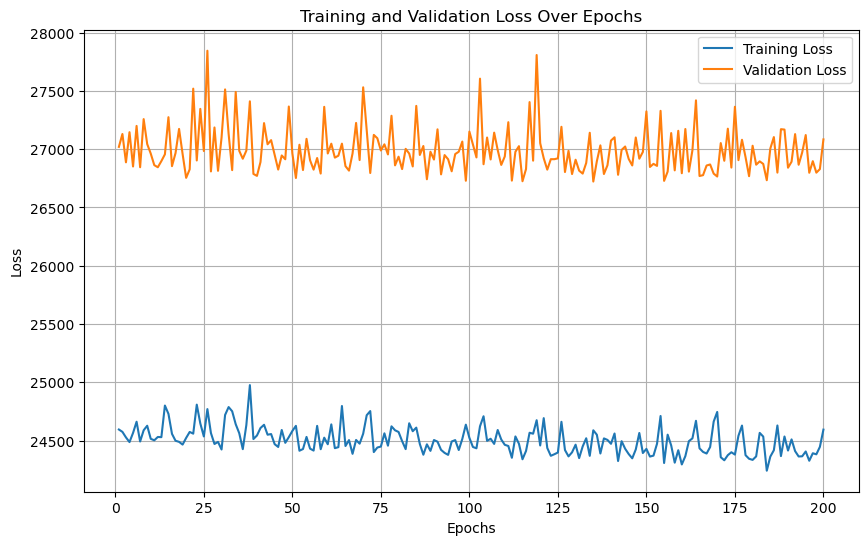

In [208]:
import matplotlib.pyplot as plt

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

# Training and Validation Loop with Loss Tracking
num_epochs = 200
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= train_size
    train_losses.append(train_loss)  # Store training loss for this epoch

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= val_size
    val_losses.append(val_loss)  # Store validation loss for this epoch

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
